<a href="https://colab.research.google.com/github/ljzier/ST-554-repo/blob/main/Task3/Task_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Project 1: Cross-Validation Algorithm (Task 3)

This task involves coding up a cross-validation algorithm to evaluate multiple linear regression models in the
time series setting.

# Load and clean the dataset for task 3.

In [28]:
# Install the ucimlrepo package available at the UC Irvine Repository
!pip install ucimlrepo

import ucimlrepo as uci
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import linear_model
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

In [2]:
air_quality = uci.fetch_ucirepo(id=360)
# view data set
air_quality = air_quality.data.features
air_quality.head()
air_quality.info()
air_quality.describe()
air_quality.isnull().sum()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9357 entries, 0 to 9356
Data columns (total 15 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Date           9357 non-null   object 
 1   Time           9357 non-null   object 
 2   CO(GT)         9357 non-null   float64
 3   PT08.S1(CO)    9357 non-null   int64  
 4   NMHC(GT)       9357 non-null   int64  
 5   C6H6(GT)       9357 non-null   float64
 6   PT08.S2(NMHC)  9357 non-null   int64  
 7   NOx(GT)        9357 non-null   int64  
 8   PT08.S3(NOx)   9357 non-null   int64  
 9   NO2(GT)        9357 non-null   int64  
 10  PT08.S4(NO2)   9357 non-null   int64  
 11  PT08.S5(O3)    9357 non-null   int64  
 12  T              9357 non-null   float64
 13  RH             9357 non-null   float64
 14  AH             9357 non-null   float64
dtypes: float64(5), int64(8), object(2)
memory usage: 1.1+ MB


,0
Date,0
Time,0
CO(GT),0
PT08.S1(CO),0
NMHC(GT),0
C6H6(GT),0
PT08.S2(NMHC),0
NOx(GT),0
PT08.S3(NOx),0
NO2(GT),0


Remove any observations where the C6H6(GT), CO(GT), T, RH, or AH are -200 as these represent missing
values.

In [3]:
print((air_quality[["C6H6(GT)", "CO(GT)", "T", "RH", "AH"]] == -200).sum())

# Create a copy to avoid modifying the original 'air_quality' directly
air_quality_temp = air_quality.copy()

# Replace -200 with NaN in the relevant columns
cols_to_clean = ["C6H6(GT)", "CO(GT)", "T", "RH", "AH"]
air_quality_temp[cols_to_clean] = air_quality_temp[cols_to_clean].replace(-200, np.nan)

# Drop rows where any of the specified columns have NaN values
air_quality_clean = air_quality_temp.dropna(subset=cols_to_clean).copy()
air_quality_clean.info()


C6H6(GT)     366
CO(GT)      1683
T            366
RH           366
AH           366
dtype: int64
<class 'pandas.core.frame.DataFrame'>
Index: 7344 entries, 0 to 9356
Data columns (total 15 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Date           7344 non-null   object 
 1   Time           7344 non-null   object 
 2   CO(GT)         7344 non-null   float64
 3   PT08.S1(CO)    7344 non-null   int64  
 4   NMHC(GT)       7344 non-null   int64  
 5   C6H6(GT)       7344 non-null   float64
 6   PT08.S2(NMHC)  7344 non-null   int64  
 7   NOx(GT)        7344 non-null   int64  
 8   PT08.S3(NOx)   7344 non-null   int64  
 9   NO2(GT)        7344 non-null   int64  
 10  PT08.S4(NO2)   7344 non-null   int64  
 11  PT08.S5(O3)    7344 non-null   int64  
 12  T              7344 non-null   float64
 13  RH             7344 non-null   float64
 14  AH             7344 non-null   float64
dtypes: float64(5), int64(8), object(2)
memory usage

 Create a new version of the data with the Date, C6H6(GT), CO(GT), T, RH, and AH

– The values of the five variables above should be their average across the given Date.


In [4]:
# Removing any columns that aren't "Date", "C6H6(GT)", "CO(GT)", "T", "RH", "AH"
air_quality_clean = air_quality_clean[["Date", "C6H6(GT)", "CO(GT)", "T", "RH", "AH"]]

# converting the date from an object to a date
air_quality_clean["Date"] = pd.to_datetime(air_quality_clean["Date"])

# Averaging the variables by date
air_data = air_quality_clean.groupby("Date").mean()

# Creating a day variable
air_data["Day"] = air_data.index.day


We will be considering two models.

The first is an SLR model using CO(GT) to predict C6H6(GT)

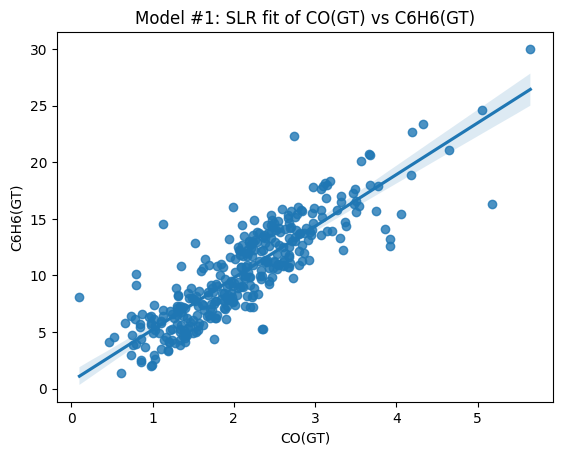

The intercept is  0.644770948344199
The coefficient is  [4.56536116]


In [14]:
# SLR

# reshaping x valley into a column instead of a 1 dimensional array
# print(air_data[["CO(GT)"]].shape)
# print(air_data["CO(GT)"].values.reshape(-1,1).shape)

# Plotting CO(GT) vs C6H6(GT)
sns.regplot(x=air_data["CO(GT)"],y=air_data["C6H6(GT)"])
plt.xlabel("CO(GT)")
plt.ylabel("C6H6(GT)")
plt.title("Model #1: SLR fit of CO(GT) vs C6H6(GT)")
plt.show()

# using the Linear model function from sklearn module to fit the SLR
# creating a regression object
air_slr = linear_model.LinearRegression()
air_slr.fit(
    air_data[["CO(GT)"]], #this is a data frame because of the [[ ]]
    air_data["C6H6(GT)"]
)

print( "The intercept is ", air_slr.intercept_)
print( "The coefficient is ", air_slr.coef_)


The second model we are considering is an MLR model using CO(GT), T, RH, and AH to predict C6H6(GT).


In [18]:
# Using using CO(GT), T, RH, and AH to predict C6H6(GT)

# using the Linear model function from sklearn module to fit the MLR
air_mlr = linear_model.LinearRegression()
air_mlr.fit(
    air_data[["CO(GT)", "T", "RH", "AH"]],
    air_data["C6H6(GT)"]
)

print( "The intercept is ", air_mlr.intercept_)
print( "The coefficients are ", air_mlr.coef_)

The intercept is  -1.8377694729981364
The coefficients are  [ 4.77080433  0.11973259 -0.01620259  0.68866811]


## Cross Validation ##

We want to see how well these two competing models do at predicting, but since we are doing time data, close days will be correlated. Instead we'll train the model and then judge it.

1. Use the first 250 days of data to fit the model. Use that model to predict the 251st day. Calculate the
MSE for that prediction.
2. Use the first 251 days of data to fit the model. Use that model to predict the 252nd day. Calculate
the MSE for that prediction.
3. Repeat until you predict for the last day.
4. Sum up the MSE values to get an overall MSE for the model!

In [47]:

# Define our X and y to save some writing
X = ["CO(GT)", "T", "RH", "AH"]
y= ["C6H6(GT)"]

# starting training size value
train_sz = 250

#initializing result dataframe
model_comp = []

# using a for loop to iterate through the process of increasing the training size
# and predicting until the end of the data is reached

for train_sz in range(250, len(air_data)):

    # split our data into a training set and a testing set
    X_train = air_data.iloc[:(train_sz)][X]
    y_train = air_data.iloc[:(train_sz)][y]
    X_test = air_data.iloc[train_sz:train_sz+1][X]
    y_test = air_data.iloc[train_sz:train_sz+1][y]

    #fit the models
    slr_fit = linear_model.LinearRegression().fit(X_train[["CO(GT)"]], y_train)
    mlr_fit = linear_model.LinearRegression().fit(X_train[X], y_train)

    #predict the next value
    slr_pred = slr_fit.predict(X_test[["CO(GT)"]])
    mlr_pred = mlr_fit.predict(X_test[X])

    #calculate MSE
    mse_slr = mean_squared_error(y_test, slr_pred)
    mse_mlr = mean_squared_error(y_test, mlr_pred)

    model_comp.append([train_sz, mse_slr, mse_mlr])

# Convert the list of results to a DataFrame and then call
pd.DataFrame(model_comp, columns=['train_size', 'mse_slr', 'mse_mlr']).sum()

,0
train_size,28906.000000
mse_slr,718.081029
mse_mlr,494.342222
